In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys, os, glob, copy, re, shutil

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS
from astropy.wcs import WCS

from astropy.io import fits

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

## Get the data

We find all the object having an SDSS spectra (rouly) in the COSMOS field and z>0.3 (a 1-deg circle) using SQL query. We use SDSS because it has a decent data query tool.

In [2]:
from astroquery.sdss import SDSS

HSC_center = SkyCoord('10h00m28.60s +02d12m21.00s')

# NOTE: Columns other than ra, dec, and z are used for querying and downloading.
sql_query = f"""
SELECT 
  p.ra, p.dec, p.z, p.bestObjID, p.run2d, p.plate, p.fiberID, p.mjd
  from specObj p, dbo.fGetNearbyObjEq({HSC_center.ra.deg}, {HSC_center.dec.deg}, 60) n
  where   
    class = 'galaxy'  
    and z > 0.3   
    and zWarning = 0
    and n.objID = p.bestObjID
"""

query_result = SDSS.query_sql(sql_query)

query_result

ra,dec,z,bestObjID,run2d,plate,fiberID,mjd
float64,float64,float64,int64,str7,int64,int64,int64
149.19564,2.1295004,0.6203755,1237651753996845629,26,481,629,51908
150.59725,1.3298556,0.5002131,1237651752923693221,v5_13_2,3829,665,55300
151.05189,2.2722065,0.498982,1237651753997632291,v5_13_2,4737,9,55630
150.72155,2.3591482,0.7264705,1237653665259193232,v5_13_2,4737,35,55630
150.53024,1.4398476,0.3700566,1237653664185320078,v5_13_2,4737,97,55630
150.352,2.2186078,0.5363253,1237651753997369829,v5_13_2,4737,107,55630
150.37717,2.3175505,0.6964074,1237653665258996122,v5_13_2,4737,119,55630
150.2996,1.6771601,0.5274369,1237651753460433699,v5_13_2,4737,139,55630
150.23336,2.4762411,0.373818,1237651754534175411,v5_13_2,4737,151,55630


Plot them in the skymap

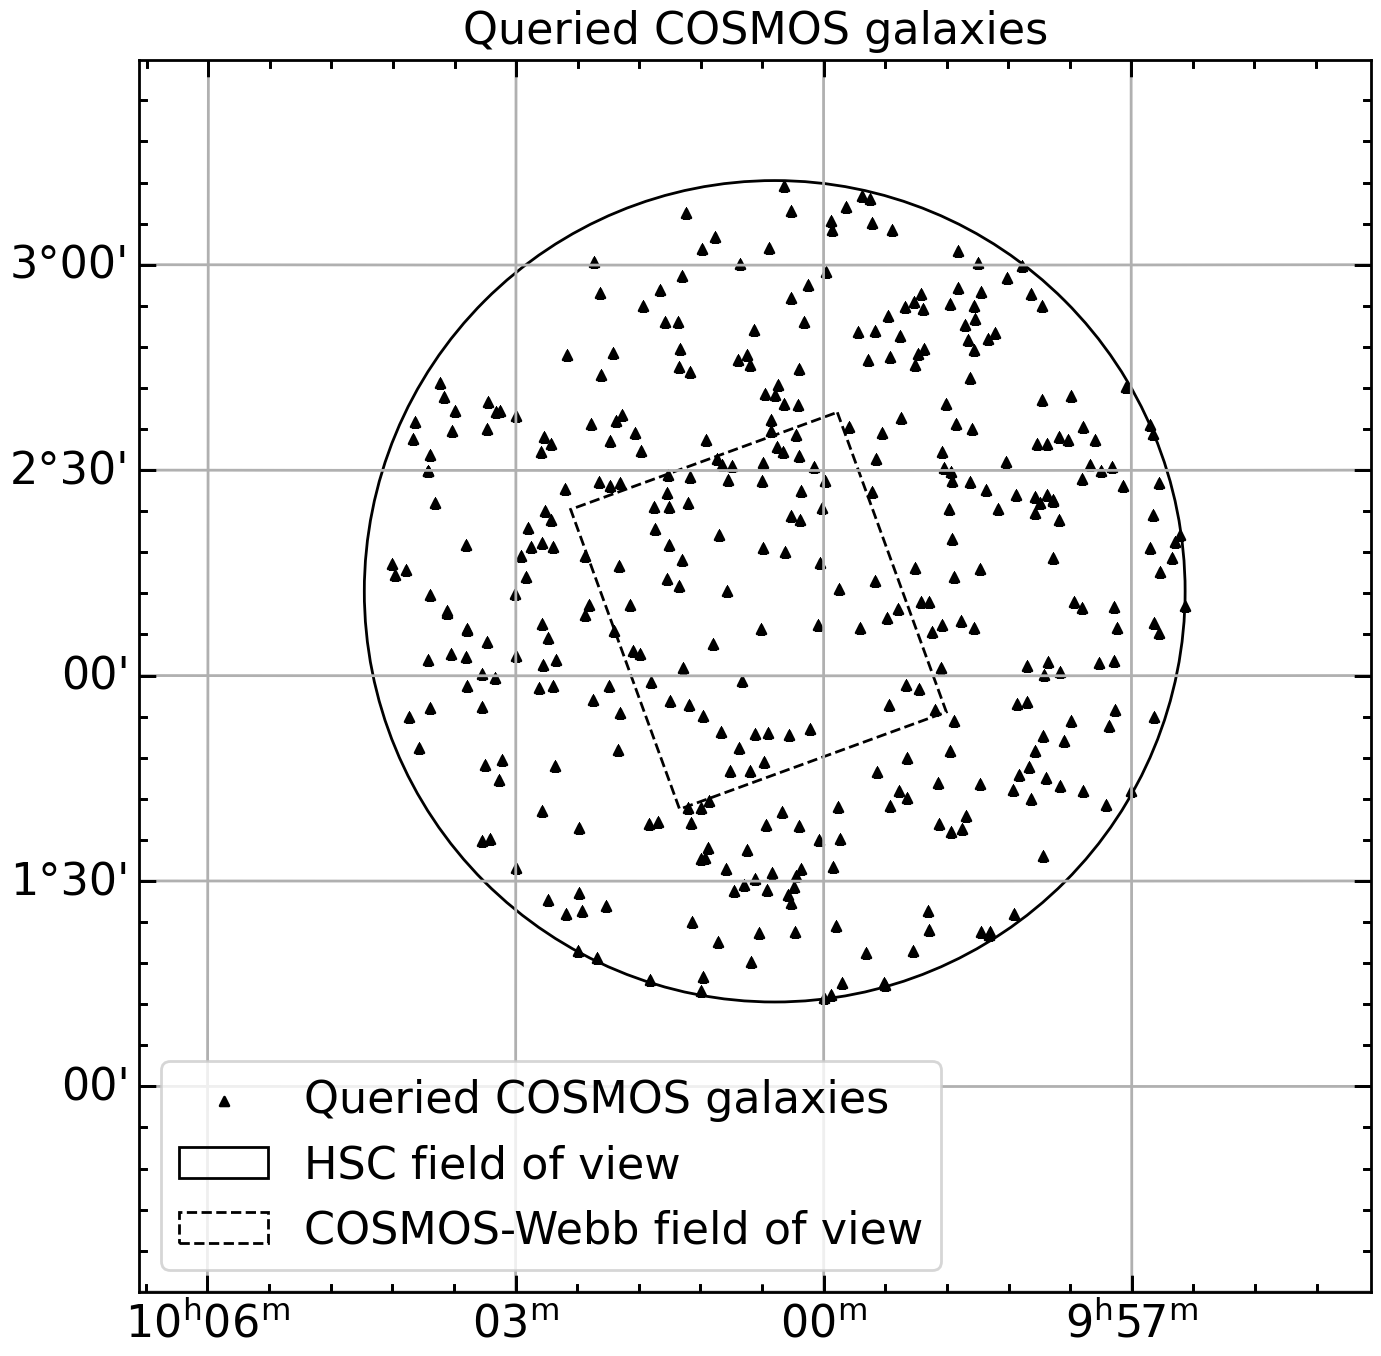

In [3]:
# Figure WCS
center_coord = SkyCoord("150d10m 2d0m")
width = 1.5*u.deg
wcs = WCS(naxis=2)
wcs.wcs.crpix = [1, 1]
wcs.wcs.cdelt = [-width.to_value(u.deg), width.to_value(u.deg)]
wcs.wcs.crval = [center_coord.ra.deg, center_coord.dec.deg]
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

fig = plt.figure(figsize=[8, 8], dpi=100)
ax1 = plt.axes(projection=wcs)
ax1.set_aspect('equal')

# Sources
ax1.scatter(query_result['ra'], query_result['dec'], 
            transform=ax1.get_transform('world'), s=10, marker='^', color='k', 
            alpha=1, label='Queried COSMOS galaxies')

# Add HSC FOV
#HSC: 10.1093/pasj/psx066 fig4
HSC_center = SkyCoord('10h00m28.60s +02d12m21.00s')
HSC_radius = 1
HSC_FOV = plt.Circle(
    (HSC_center.ra.value, HSC_center.dec.value), HSC_radius, fill=False, 
    transform=ax1.get_transform('world'), label='HSC field of view'
)
ax1.add_artist(HSC_FOV)

# Add COSMOS-Webb FOV
#Webb: 2211.07865 fig1
Webb_center = SkyCoord('10h00m27.9s +02d12m03.5s')
Webb_width = 41.5/60
Webb_height = 46.6/60
Webb_angle = 110
Webb_FOV = plt.Rectangle(
    (Webb_center.ra.value-Webb_width/2, Webb_center.dec.value-Webb_height/2), 
    Webb_height, Webb_width, rotation_point='center', angle=-110, 
    linestyle='--', fill=False, transform=ax1.get_transform('world'), 
    label='COSMOS-Webb field of view'
)
ax1.add_artist(Webb_FOV)

ax1.grid()
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)
ax1.legend(loc='lower left', frameon=True)
ax1.set_title('Queried COSMOS galaxies')
ax1.set_xlim(-1, 1) # using deg as unit as defined in wcs.wcs.cdelt
ax1.set_ylim(-1, 1)
# fig.savefig('cosmos.eps', format='eps')
plt.show()

We then download all the spectra we just got.

In [ ]:
# # NOTE: For MAGNIF users, the data is already downloaded and stored at /home/yichenliu/machine-learning-demo/data .

# batch_size = 10
# outdir = 'data'
# os.makedirs(outdir, exist_ok=True)

# for i in range(0, len(query_result), batch_size):
#     batch = query_result[i:min(i + batch_size, len(query_result)-1)]
#     print(f'Downloading batch {i} to {i + batch_size - 1}...')
#     sp = SDSS.get_spectra(matches=batch)
#     for j, spectrum in enumerate(sp):
#         obj_id = batch['bestObjID'][j]
#         z = batch['z'][j]
#         filename = os.path.join(outdir, f'spectrum_id_{obj_id}_z_{z}.fits')
#         spectrum.writeto(filename, overwrite=True)
#         # print(f'  Saved: {filename}')
# print('Finish Downloading.')

Now we show how to display a SDSS spectrum.

Filename: data/spectrum_id_1237653664721732214_z_0.37759.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     121   ()      
  1  COADD         1 BinTableHDU     26   4633R x 8C   ['E', 'E', 'E', 'J', 'J', 'E', 'E', 'E']   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 

[ 38.31649   -17.491781  -13.90365   ...  -2.6476817  -1.2051308
   1.1768582]
<class 'numpy.ndarray'>


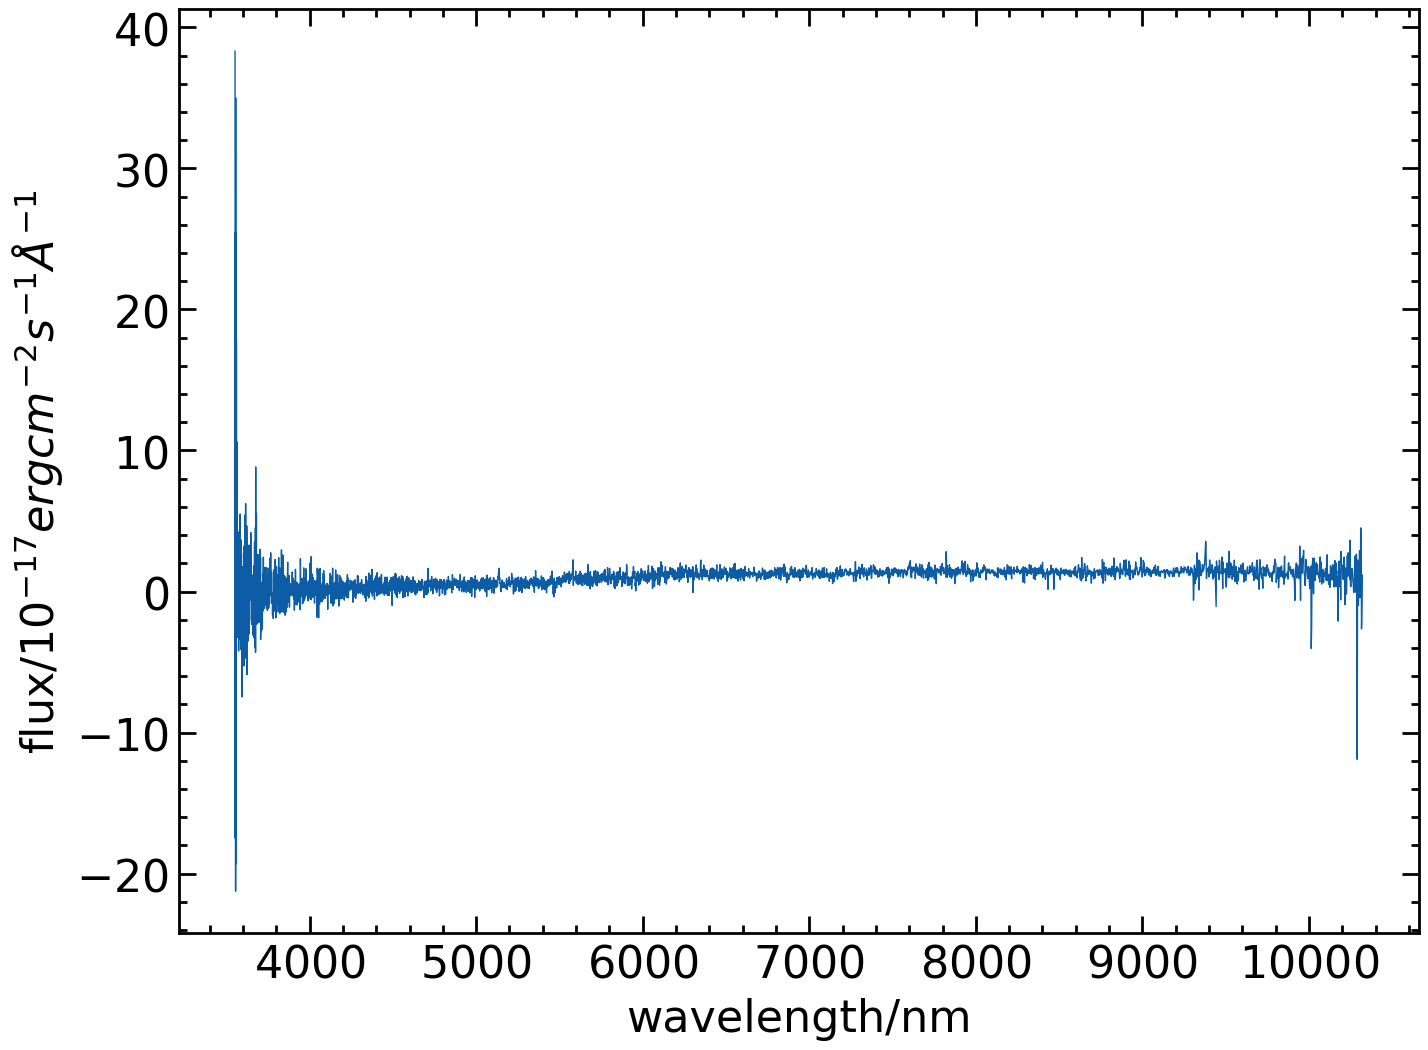

In [5]:
# NOTE: Naming Convention I used: 
# NOTE: xxx_dir for directory only
# NOTE: xxx_name for filename only
# NOTE: xxx_path for a full path like 'directory/filename'
# NOTE: xxx_xxx + s means a list of xxx

data_dir = 'data'
data_names = os.listdir(data_dir)
data_paths = [os.path.join(data_dir, name) for name in data_names]

with fits.open(data_paths[0]) as hdu: 
    mask = np.isfinite(hdu[1].data['flux'])
    wavelengths = 10**hdu[1].data['loglam'][mask]
    flux_sdss = hdu[1].data['flux'][mask]
    # print and display data
    hdu.info()
    print(flux_sdss)
    print(type(flux_sdss))
    plt.plot(10**hdu[1].data['loglam'][mask], flux_sdss, 
             label=f'exmple SDSS spectrum', linewidth=0.5)
    plt.xlabel('wavelength/nm')
    plt.ylabel(r'flux/$10^{-17} erg cm ^{-2} s^{-1} \AA^{-1}$')
    plt.show()
    

## Now we use Pytorch to build a simple framework to predict the redshift.

In [6]:
# NOTE: The code blocks below can run without running blocks above.

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from astropy.io import fits
from torch.optim.lr_scheduler import StepLR, MultiStepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Define the dataset and dataloader

In [7]:
# Define the Dataset
class SpectrumDataset(Dataset):
    def __init__(self, data_dir, max_length=5000):
        self.data_paths = [os.path.join(data_dir, name) for name in os.listdir(data_dir)]
        self.data_paths.sort()
        self.max_length = max_length

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        data_path = self.data_paths[idx]
        with fits.open(data_path) as hdu:
            mask = np.isfinite(hdu[1].data['flux'])
            wavelengths = 10**hdu[1].data['loglam'][mask]
            flux = hdu[1].data['flux'][mask]

            # Normalize and pad
            flux = (flux - np.mean(flux)) / np.std(flux)
            wavelengths = (wavelengths - np.mean(wavelengths)) / np.std(wavelengths)
            data = np.stack([wavelengths, flux], axis=1)
            if len(data) > self.max_length:
                data = data[:self.max_length]
            else:
                padding = np.zeros((self.max_length - len(data), 2))
                data = np.vstack([data, padding])

        redshift = float(data_path.split('_z_')[-1].replace('.fits', ''))
        return torch.tensor(data, dtype=torch.float32), torch.tensor(redshift, dtype=torch.float32)

# Prepare DataLoader
data_dir = 'data'
dataset = SpectrumDataset(data_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Define the Model

In [8]:
class RedshiftPredictor(nn.Module):
    def __init__(self):
        super(RedshiftPredictor, self).__init__()
        # Sequence model: LSTM
        self.lstm = nn.LSTM(input_size=2, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),  # Reduce LSTM output to smaller dimensions
            nn.ReLU(),
            nn.Linear(64, 1)    # Final output: redshift
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, 2]
        lstm_out, _ = self.lstm(x)  # Output shape: [batch_size, sequence_length, 128]
        lstm_out = lstm_out.mean(dim=1)  # Aggregate across sequence dimension
        return self.fc(lstm_out)  # Final prediction: [batch_size, 1]

Initialize Model, Loss Function, and Optimizer, and then train the model

Epoch 1/150, LR: 0.003, Loss: 0.021295
Epoch 2/150, LR: 0.003, Loss: 0.006909
Epoch 3/150, LR: 0.003, Loss: 0.015957
Epoch 4/150, LR: 0.003, Loss: 0.011944
Epoch 5/150, LR: 0.003, Loss: 0.018570
Epoch 6/150, LR: 0.003, Loss: 0.012620
Epoch 7/150, LR: 0.003, Loss: 0.019471
Epoch 8/150, LR: 0.003, Loss: 0.007144
Epoch 9/150, LR: 0.003, Loss: 0.003500
Epoch 10/150, LR: 0.003, Loss: 0.013140
Epoch 11/150, LR: 0.003, Loss: 0.011701
Epoch 12/150, LR: 0.003, Loss: 0.005302
Epoch 13/150, LR: 0.003, Loss: 0.007051
Epoch 14/150, LR: 0.003, Loss: 0.014623
Epoch 15/150, LR: 0.003, Loss: 0.002517
Epoch 16/150, LR: 0.003, Loss: 0.024559
Epoch 17/150, LR: 0.003, Loss: 0.008137
Epoch 18/150, LR: 0.003, Loss: 0.004970
Epoch 19/150, LR: 0.003, Loss: 0.008530
Epoch 20/150, LR: 0.003, Loss: 0.006563
Epoch 21/150, LR: 0.003, Loss: 0.007386
Epoch 22/150, LR: 0.003, Loss: 0.012720
Epoch 23/150, LR: 0.003, Loss: 0.018510
Epoch 24/150, LR: 0.003, Loss: 0.026415
Epoch 25/150, LR: 0.003, Loss: 0.008395
Epoch 26/

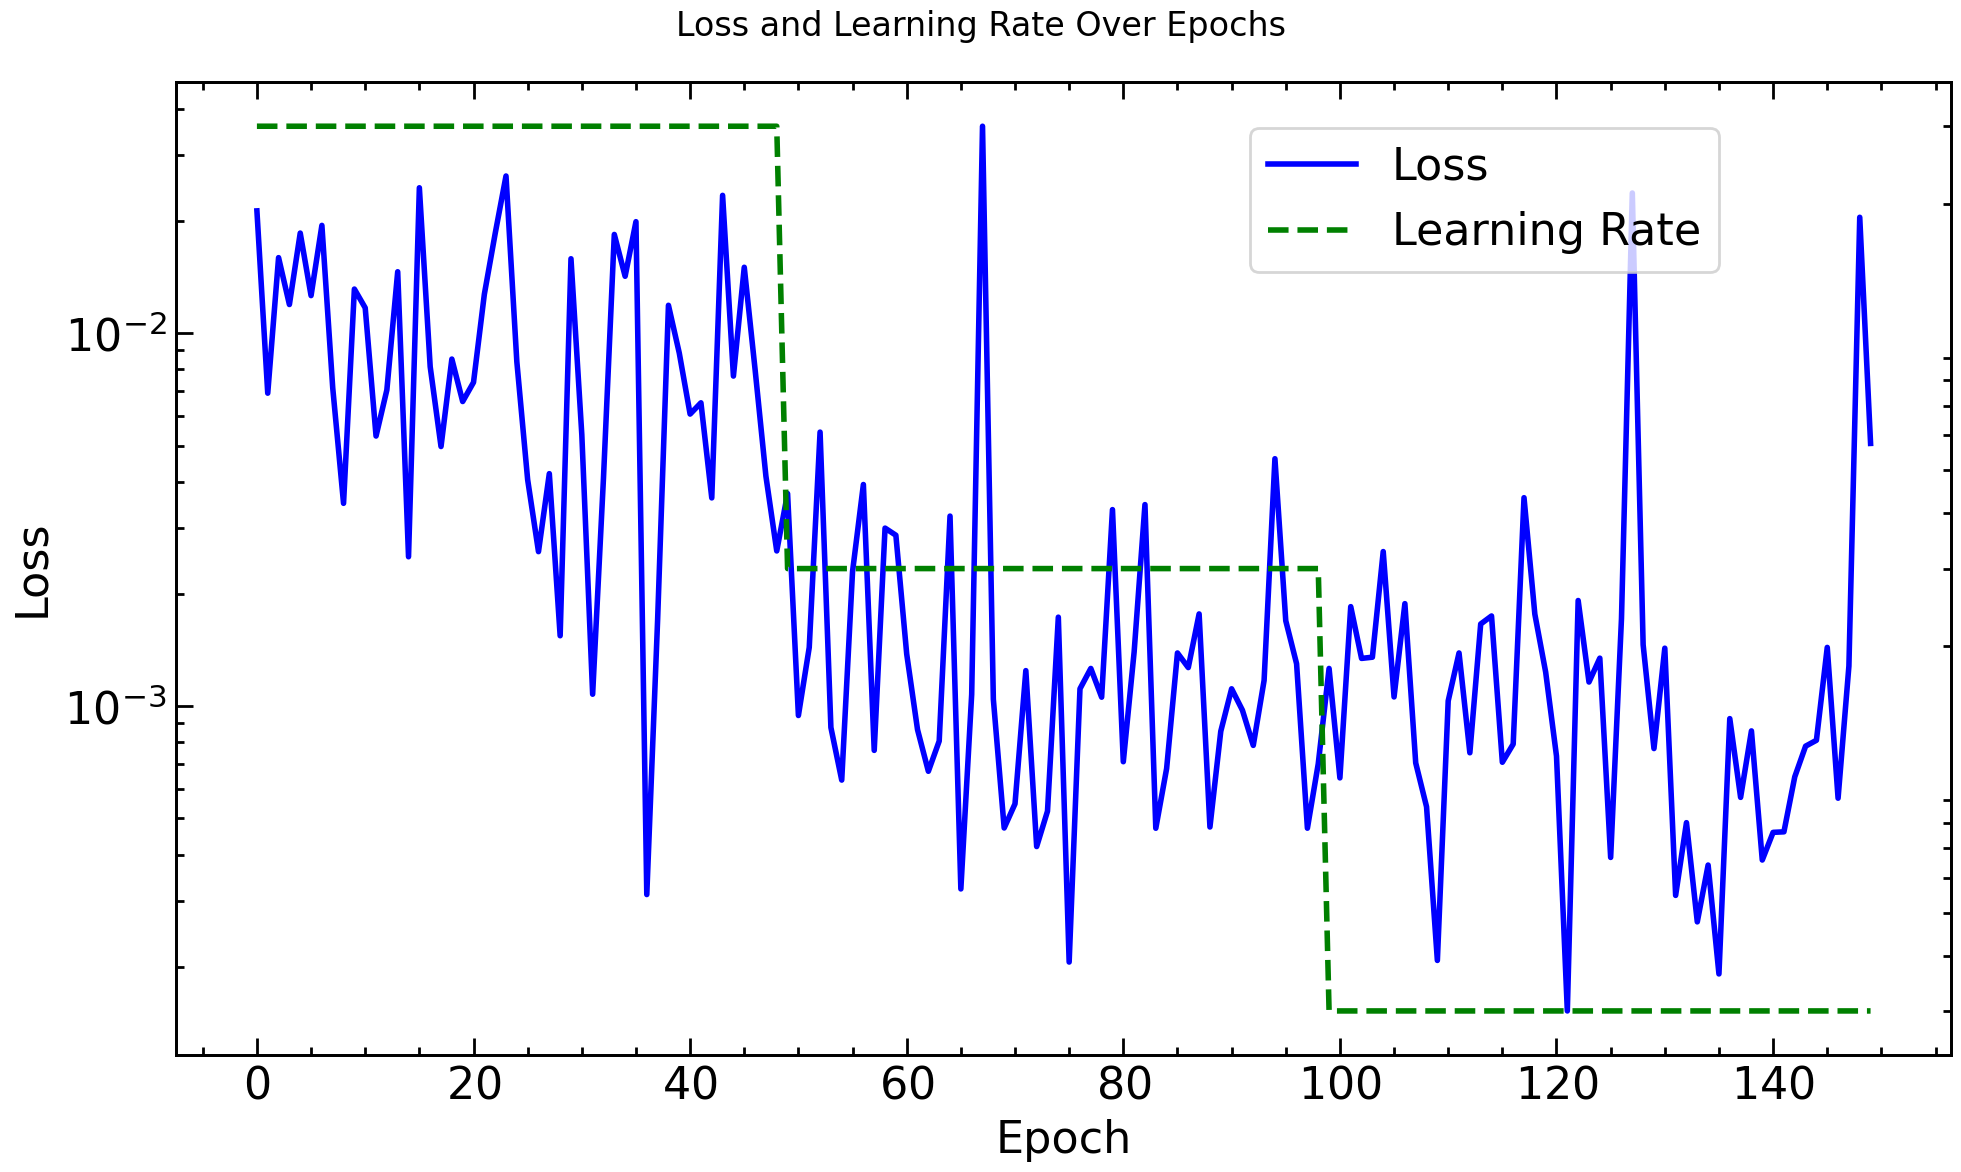

In [9]:
model = RedshiftPredictor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)

epochs = 150
losses = []
lrs = []
for epoch in range(epochs):
    model.train()
    for spectra, redshift in train_loader:
        # spectra shape: [batch_size, max_length, 2]
        # redshift shape: [batch_size]
        spectra = spectra.to(device)
        redshift = redshift.to(device)
        predictions = model(spectra)  # Output: [batch_size, 1]
        redshift = redshift.view(-1, 1)  # Match output shape
        loss = criterion(predictions, redshift)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    losses.append(loss.item())
    lrs.append(current_lr)
    print(f"Epoch {epoch+1}/{epochs}, LR: {current_lr:.6g}, Loss: {loss.item():6f}")


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot loss on the left y-axis
ax1.semilogy(range(epochs), losses, 'b-', label='Loss')  # Blue line for loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')
# ax1.set_ylim(0, max(losses) * 1.1)  # Adjust y-axis limits for loss

# Create a secondary axis for the learning rate
ax2 = ax1.twinx()
ax2.plot(range(epochs), lrs, 'g--', label='Learning Rate')  # Red dashed line for LR
ax2.semilogy('Learning Rate')
ax2.tick_params(axis='y')
# ax2.set_ylim(0, max(lrs) * 1.1)  # Adjust y-axis limits for LR

# Add a title and legends
fig.suptitle('Loss and Learning Rate Over Epochs')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.9), frameon=True)

# Show the plot
plt.show()

Now we evaluate the model.

Test Loss: 0.0006564814576449862


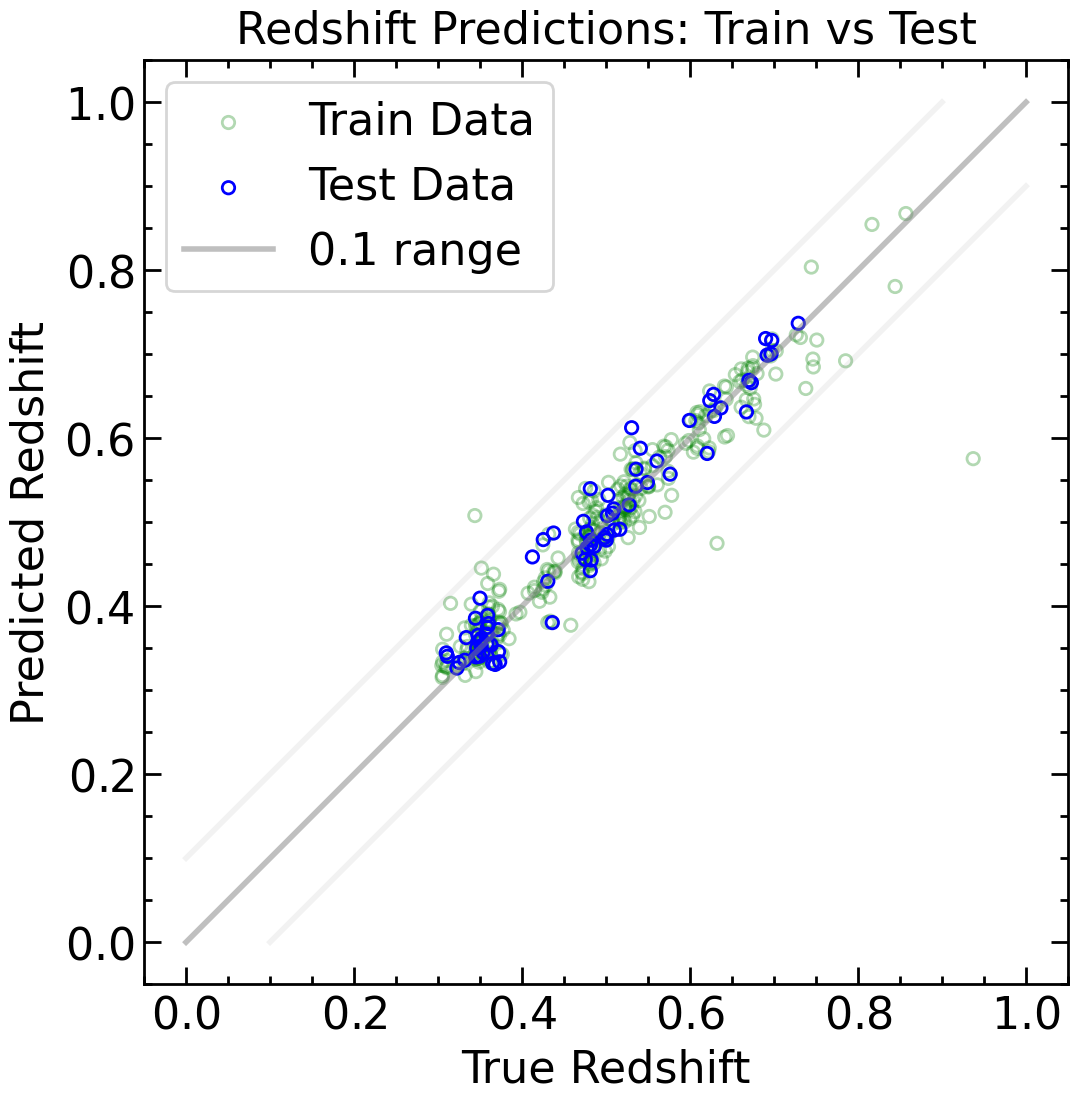

In [10]:
# set the model to evaluate mode
model.eval()

train_redshift, train_predictions = [], []
test_redshift, test_predictions = [], []

# Collect train data
with torch.no_grad():
    for spectra, redshift in train_loader:
        redshift = redshift.view(-1, 1)
        spectra = spectra.to(device)
        redshift = redshift.to(device)
        predictions = model(spectra)
        train_redshift.append(redshift)
        train_predictions.append(predictions)

# Collect test data
with torch.no_grad():
    total_loss = 0
    for spectra, redshift in test_loader:
        redshift = redshift.view(-1, 1)
        spectra = spectra.to(device)
        redshift = redshift.to(device)
        predictions = model(spectra)
        loss = criterion(predictions, redshift)
        total_loss += loss.item()
        test_redshift.append(redshift)
        test_predictions.append(predictions)
    print(f"Test Loss: {total_loss / len(test_loader)}")

# Combine data and plot
train_redshift = torch.cat(train_redshift).cpu().numpy()
train_predictions = torch.cat(train_predictions).cpu().numpy()
test_redshift = torch.cat(test_redshift).cpu().numpy()
test_predictions = torch.cat(test_predictions).cpu().numpy()

plt.scatter(train_redshift, train_predictions, edgecolors='green', s=20,
            facecolors='none', alpha=0.3, label='Train Data')
plt.scatter(test_redshift, test_predictions, edgecolors='blue', s=20,
            facecolors='none', alpha=1.0, label='Test Data')

# Add legend and labels
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Predictions: Train vs Test')
plt.plot([0, 1], [0, 1], alpha=0.5, c='gray', label='0.1 range')
plt.plot([0.1, 1], [0, 0.9], c='gray', alpha=0.1)
plt.plot([0, 0.9], [0.1, 1], c='gray', alpha=0.1)
plt.gca().set_aspect('equal')
plt.legend(frameon=True)
plt.show()

## Now we use random forest to achieve a similar redshift prediction.

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Flatten the spectral data for Random Forest
def preprocess_data(loader):
    features, targets = [], []
    for spectra, redshift in loader:
        # Flatten each spectrum (sequence_length, 2) -> (sequence_length*2)
        spectra_flat = spectra.view(spectra.shape[0], -1).numpy()
        features.append(spectra_flat)
        targets.append(redshift.numpy())
    return np.vstack(features), np.hstack(targets)

We first show decision tree (can be considered as a part of random forest)

In [13]:
# Preprocess data
train_features, train_targets = preprocess_data(train_loader)
test_features, test_targets = preprocess_data(test_loader)

# Initialize Decision Tree Regressor with custom parameters
dt_model = DecisionTreeRegressor(
    max_depth=15,              # Limit the depth of the tree
    min_samples_split=5,       # Minimum samples to split a node
    min_samples_leaf=3,        # Minimum samples at a leaf node
    max_features=None,         # Consider all features at each split
    random_state=42            # Fix random seed for reproducibility
)

# Train the model
dt_model.fit(train_features, train_targets)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      random_state=42)

Train MSE: 0.0003575174784226509
Test MSE: 0.0070222273786127425


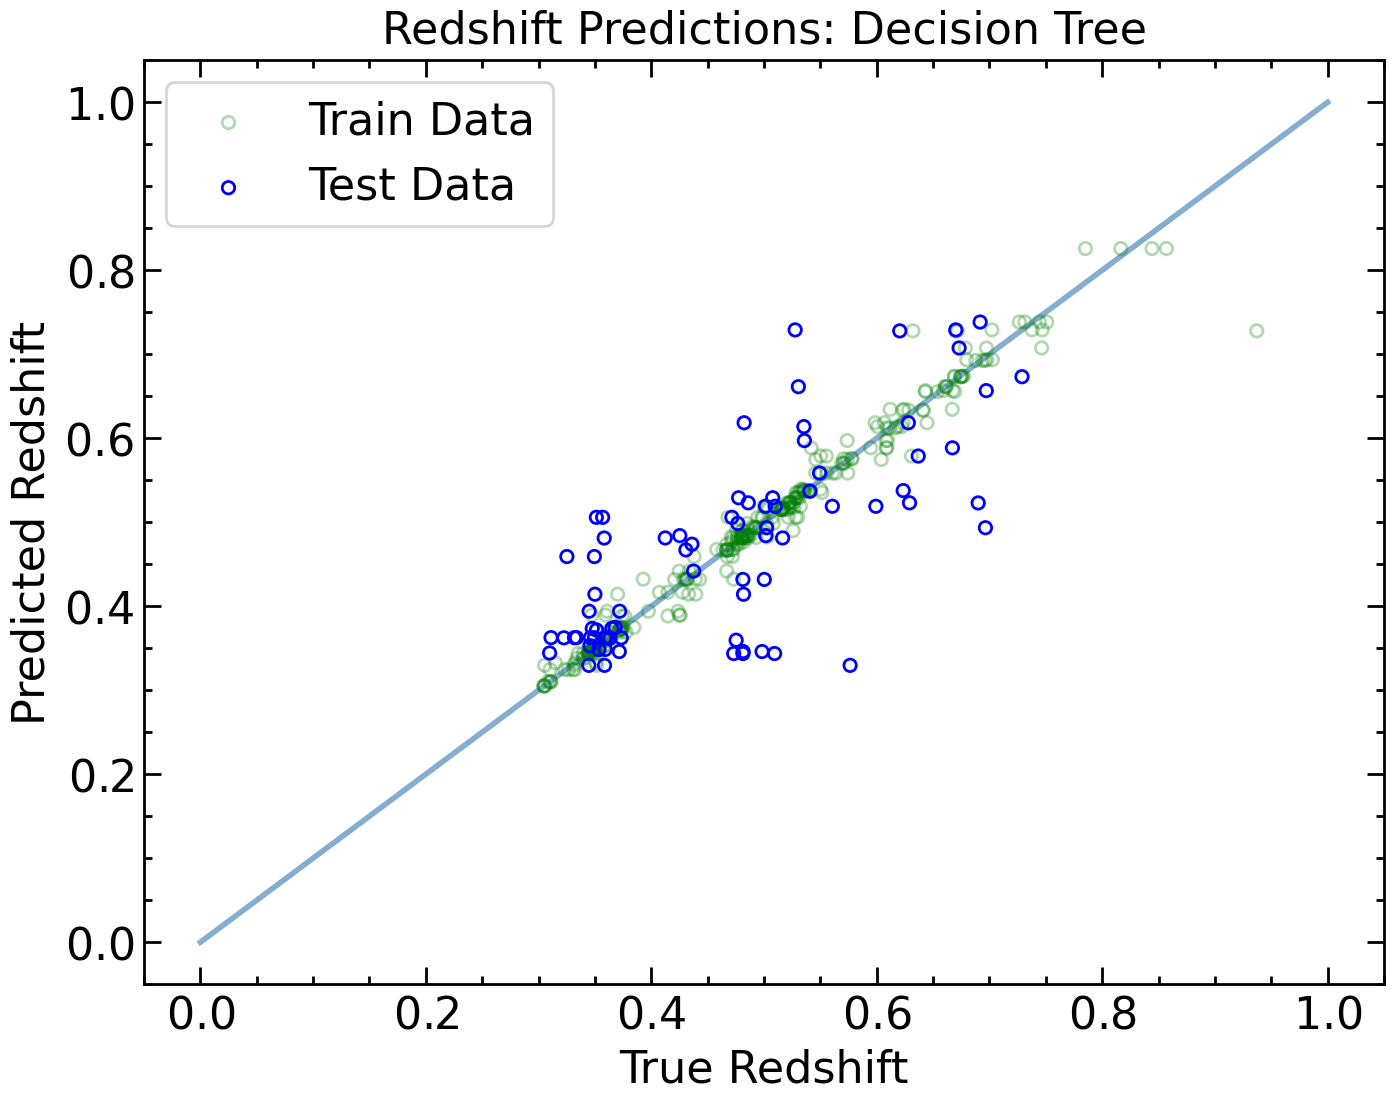

In [14]:
# Make predictions
train_predictions = dt_model.predict(train_features)
test_predictions = dt_model.predict(test_features)

# Compute MSE
train_mse = mean_squared_error(train_targets, train_predictions)
test_mse = mean_squared_error(test_targets, test_predictions)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


# Visualize predictions
plt.scatter(train_targets, train_predictions, edgecolors='green', 
            facecolors='none', alpha=0.3, label='Train Data', s=20)
plt.scatter(test_targets, test_predictions, edgecolors='blue', 
            facecolors='none', alpha=1.0, label='Test Data', s=20)
plt.legend(frameon=True)
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Predictions: Decision Tree')
plt.plot([0, 1], [0, 1], alpha=0.5, zorder=0)
plt.show()

Now we can move on to random forest. 

In [15]:
# Prepare the train and test data
train_features, train_targets = preprocess_data(train_loader)
test_features, test_targets = preprocess_data(test_loader)

# Initialize Random Forest Regressor with custom parameters
rf_model = RandomForestRegressor(
    n_estimators=100,       # Use 200 trees instead of the default 100
    max_depth=15,           # Limit the depth of each tree to 15
    # min_samples_split=5,    # Require at least 5 samples to split
    # min_samples_leaf=2,     # Require at least 2 samples in leaf nodes
    # max_features='sqrt',    # Use the square root of features for each split
    random_state=42         # Set random seed for reproducibility
)

rf_model.fit(train_features, train_targets)

RandomForestRegressor(max_depth=15, random_state=42)

Train MSE: 0.0008040269503932504
Test MSE: 0.002418337428370868


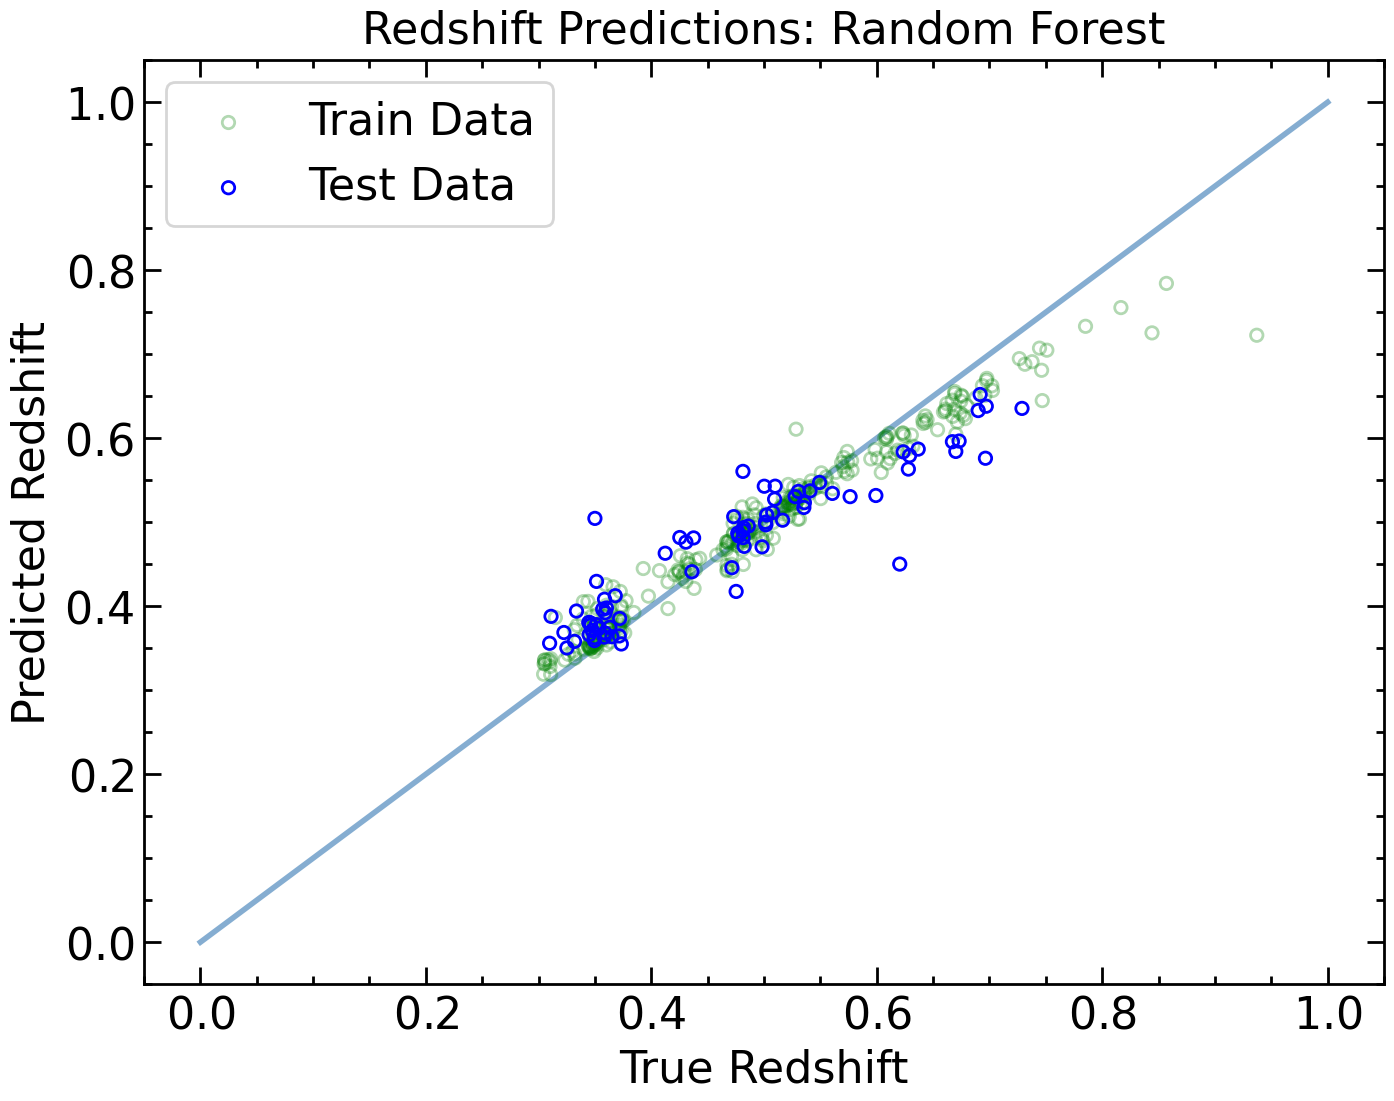

In [16]:
# Make predictions
train_predictions = rf_model.predict(train_features)
test_predictions = rf_model.predict(test_features)

# Compute MSE
train_mse = mean_squared_error(train_targets, train_predictions)
test_mse = mean_squared_error(test_targets, test_predictions)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


# Visualize predictions
plt.scatter(train_targets, train_predictions, edgecolors='green', 
            facecolors='none', alpha=0.3, label='Train Data', s=20)
plt.scatter(test_targets, test_predictions, edgecolors='blue', 
            facecolors='none', alpha=1.0, label='Test Data', s=20)
plt.legend(frameon=True)
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Predictions: Random Forest')
plt.plot([0, 1], [0, 1], alpha=0.5, zorder=0)
plt.show()

For people more interested in random forest, here is a sturcute of it.

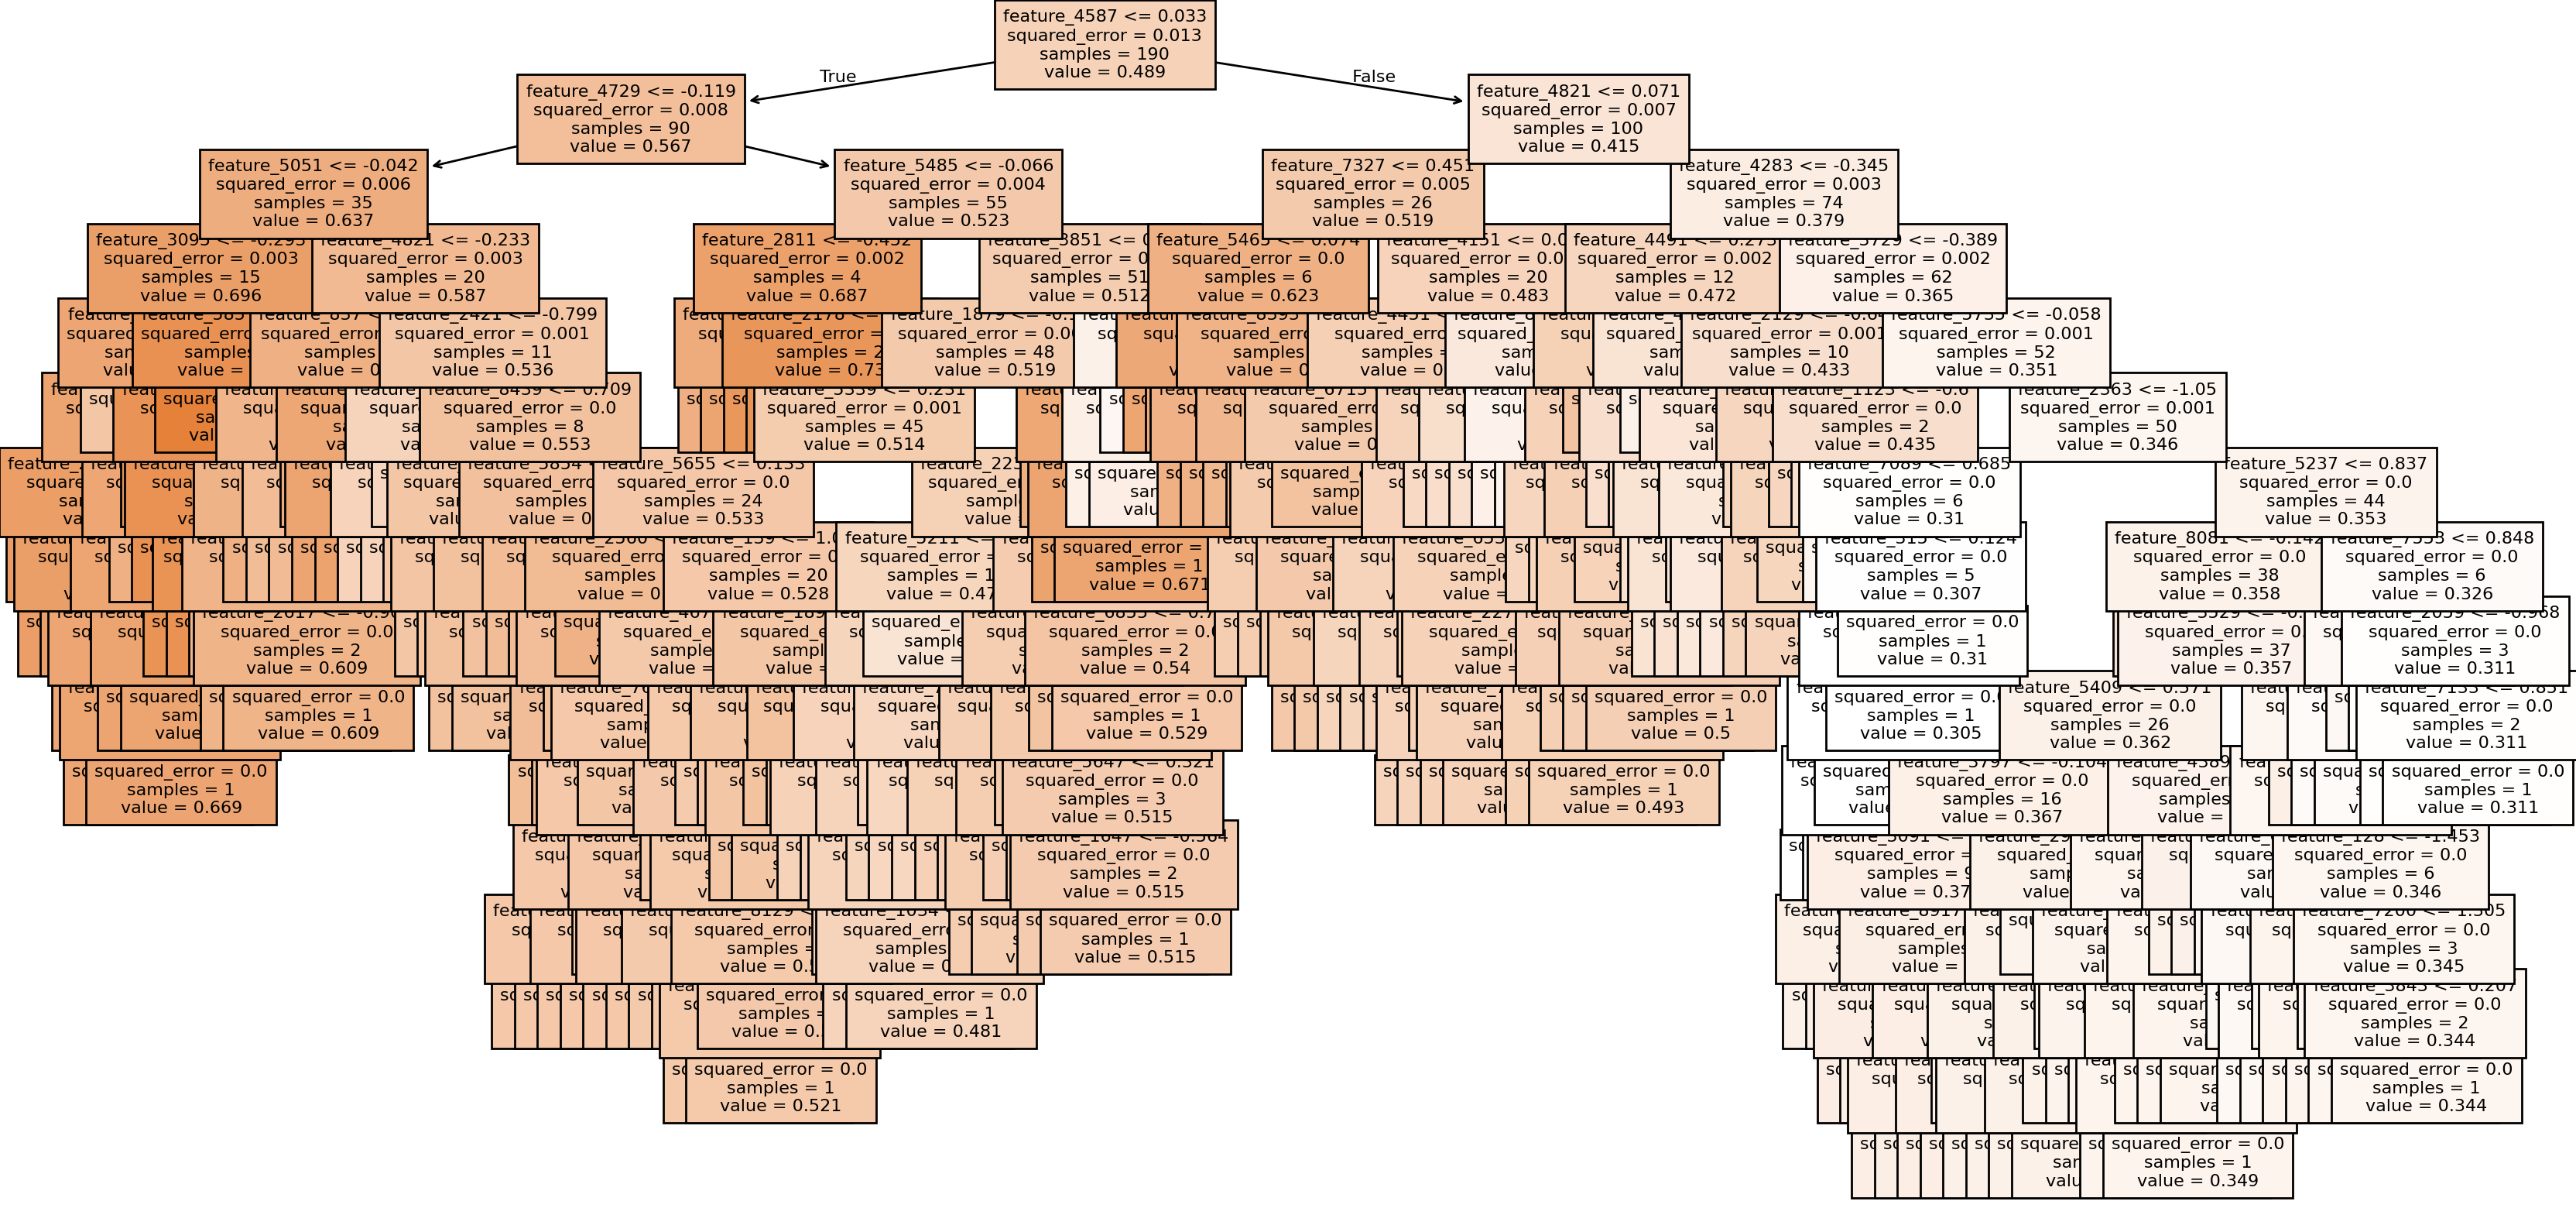

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the first tree in the forest
tree = rf_model.estimators_[0]

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=[f'feature_{i}' for i in range(train_features.shape[1])], filled=True, fontsize=8)
plt.show()
